In [10]:
import sys
sys.path.append('../..')

import math
import matplotlib.pyplot as plt
import numpy as np

import navbench as nb
import navbench.improc as ip
from navbench.infomax import InfoMax

IM_SIZE = (90, 25)
RIDF_STEP = 1
RESIZE     = ip.resize(*IM_SIZE)
PREPROC    = (RESIZE) #, ip.remove_sky_and_histeq)
SNAP_STEP  = 10
NUM_HIDDEN = IM_SIZE[0] * IM_SIZE[1]
INFOMAX_RANDOM_SEED = 42
INFOMAX_LEARNING_RATE = InfoMax.DEFAULT_LEARNING_RATE
DBROOT = '../../datasets/rc_car/Stanmer_park_dataset'

names = ['0511/unwrapped_dataset%d' % num for num in range(1, 6)]
descriptions = ['0 m away', '0 m away (repeat)', '1 m away (left)',
                '1 m away (right)', '2 m away (right)']
dbs = []
images = []

def load_db(path):
    db = nb.Database(os.path.join(DBROOT, path))
    print('Database %s has %d images' % (path, len(db)))
    return db

# Plot UTM coordinates
def plot_route(ax, db, *args, **kwargs):
    return ax.plot(db.x, db.y, *args, **kwargs)

def get_heading_offset(db, dists):
    i = 0
    while dists[i] < 0.5:
        i += 1
    
    offset = db.position[i, :] - db.position[0, :]
    return math.atan2(offset[1], offset[0])

def ridf_to_radians(diffs):
    bestcols = np.argmin(diffs, axis=-1)
    ths = 2 * math.pi * bestcols / diffs.shape[-1]
    return ths

def get_ridf(ims, fun):
    return [ridf_to_radians(fun(im)) for im in ims]

def plot_arrows(ax, ridf_fun):
    test_dists = range(0, 55, 3)
    for db, route_images, line in zip(dbs, images, lines):
        colour = line[0].get_color()
        distances = np.array(db.get_cumulative_distances())
        head_offset = get_heading_offset(db, distances)
        test_frames = [np.argmin(np.abs(distances - test_dist)) for test_dist in test_dists]

        heads = ridf_fun([route_images[fr] for fr in test_frames])
        heads = [head + head_offset for head in heads]
        x = [db.x[i] for i in test_frames]
        y = [db.y[i] for i in test_frames]
        u = [math.cos(head) for head in heads]
        v = [math.sin(head) for head in heads]

        ax.quiver(x, y, u, v, color=colour, zorder=10, scale_units='xy', scale=0.5)

for name in names:
    dbs.append(load_db(name))
    images.append(dbs[-1].read_images(preprocess=PREPROC, to_float=False))

Loading database at ../../datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset1...
Database 0511/unwrapped_dataset1 has 411 images
Loading database at ../../datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset2...
Database 0511/unwrapped_dataset2 has 367 images
Loading database at ../../datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset3...
Database 0511/unwrapped_dataset3 has 402 images
Loading database at ../../datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset4...
Database 0511/unwrapped_dataset4 has 452 images
Loading database at ../../datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset5...
Database 0511/unwrapped_dataset5 has 386 images


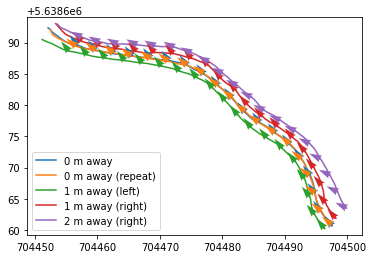

In [11]:
snapshots = images[0][0::SNAP_STEP]

def get_ridf_pixel(ims, snapshots):
    heads = []
    for im in ims:
        diffs = nb.ridf(im, snapshots, step=RIDF_STEP)
        best_over_rot = np.min(diffs, axis=1)
        best_row = np.argmin(best_over_rot)
        heads.append(ridf_to_radians(diffs[best_row, :]))
        return heads

_, ax = plt.subplots()
ax.axis('equal')
lines = [plot_route(ax, db) for db in dbs]
plot_arrows(ax, lambda ims: get_ridf_pixel(ims, snapshots))
ax.legend(descriptions);

Using cached result from '.navbench_cache/ipython_get_ann_b47efae28e0738cf77307da97ef2046ac35f155190cd405837a41099cf3b901d.pkl'
get_ann() took 37.3226 s to run (without caching)
Using cached result from '.navbench_cache/ipython_get_ridf_infomax_b8565b23d0797d3c427ec3c6c0ea8a6359272764831c11b4d934026c88a9b465.pkl'
get_ridf_infomax() took 8.68838 s to run (without caching)
Using cached result from '.navbench_cache/ipython_get_ridf_infomax_c7e9caaca5114c51c323252f1d592d04ca972b9fd3fde6a9fc0ffe7a48f9c2a3.pkl'
get_ridf_infomax() took 8.69775 s to run (without caching)
Using cached result from '.navbench_cache/ipython_get_ridf_infomax_522229c260f756a30b4fb7e78f9b4999f97ab7c8097189e19e94d42868cafdad.pkl'
get_ridf_infomax() took 8.69981 s to run (without caching)
Using cached result from '.navbench_cache/ipython_get_ridf_infomax_f676124f4a6b6e28c44d3aea0115893ec31d7fb6cae298facd2be3655b67bbde.pkl'
get_ridf_infomax() took 8.77328 s to run (without caching)
Using cached result from '.navbench_ca

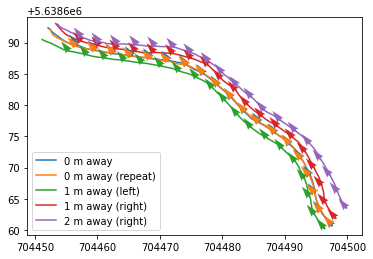

In [12]:
import pathos.multiprocessing as mp

from navbench.infomax import InfoMax

@nb.cache_result
def get_ann(snapshots, num_hidden, lrate, seed):
    assert not seed is None

    ann = InfoMax(snapshots[0].size, num_hidden, learning_rate=lrate, seed=seed)
    for snap in snapshots:
        ann.train(snap)
    return ann

@nb.cache_result
def get_ridf_infomax(ann, ims, step):
    pool = mp.Pool()
    return pool.map(lambda im: ridf_to_radians(ann.ridf(im, step=RIDF_STEP)), ims)

ann = get_ann(images[0], NUM_HIDDEN, INFOMAX_LEARNING_RATE, INFOMAX_RANDOM_SEED)

_, ax = plt.subplots()
ax.axis('equal')
lines = [plot_route(ax, db) for db in dbs]

plot_arrows(ax, lambda im: get_ridf_infomax(ann, im, RIDF_STEP))
ax.legend(descriptions);